# Lens modeling of DESIJ1101-0602 with `lenstronomy`

**Author:** Jannatul Ferdous, Fahim Rajit Hossain

In [1]:
# import of standard python libraries
!pip install emcee
import emcee
!pip install corner
import corner
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util import util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.11.2-py3-none-any.whl size=1086826 sha256=9ed65fb39d7ffdab956a1f52f8c58e617e449075cb2fbb43ac7c61ec17fa17bb
  Stored in directory: /root/.cache/pip/wheels/1c/62/fa/1c6f5bd9f9e9e37978c5ef811810e69118ea87f2a1cd0b946d
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15728 sha256=cf1ef333b9060c460f29ff93e939e376fd8ff58053377bfa8a02783059dfa947
  Stored in directory: /root/.cache/pip/wheels/4a/ea/3e/b79646d96eaea548b8e

## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

In [4]:
# load HDF5 file

with h5py.File('/content/drive/MyDrive/BDLensing/DESIJ1101-0602_F140W.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

# load HDF5 psf file using h5py
with h5py.File('/content/drive/MyDrive/BDLensing/psf_F140W.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf['psf_type'] = 'PIXEL'
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

In [5]:
image_size = kwargs_data['image_data'].shape
print(image_size)

(180, 180)


<ipython-input-6-3fa448f29b79>:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data']), origin='lower',


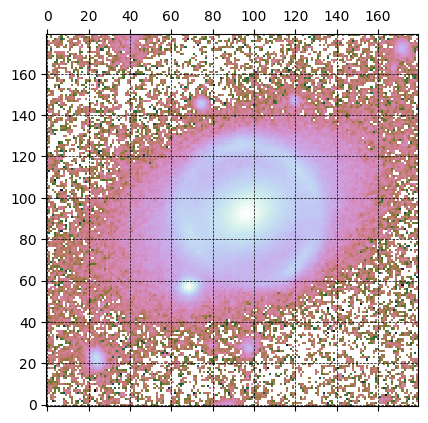

In [6]:
plt.matshow(np.log10(kwargs_data['image_data']), origin='lower',
            cmap='cubehelix')
plt.grid(True, which='both', linewidth=0.5, linestyle = '--', color='black')

plt.xticks(np.arange(0, 180, 20))
plt.yticks(np.arange(0, 180, 20))

plt.show()

# Creating Likelihood Mask

A likelihood mask is a tool used in statistical analysis, particularly in Bayesian statistics, to identify data points that have a strong influence on the final results of a model. It is a binary mask that identifies which data points in the model contribute to the likelihood function, and which data points do not.

In practical terms, a likelihood mask can be created by setting a threshold for the quality of the data, such as the signal-to-noise ratio or the uncertainty in the measurements. Data points that do not meet this threshold can be masked out, effectively removing them from the analysis. This can help to improve the accuracy and precision of the model by reducing the impact of noisy or unreliable data.

Likelihood masks can also be used to exclude regions of the data that are known to be problematic, such as areas affected by foreground contamination, instrumental effects, or other sources of systematic error. By excluding these regions from the analysis, the likelihood mask can help to improve the robustness and reliability of the model.

In [7]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle,
                     ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 6 # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

# mask_outer_2 = mask_util.mask_center_2d(
#     lens_center_ra,
#     lens_center_dec,
#     r2,
#     util.image2array(x_coords),
#     util.image2array(y_coords),)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.9,
    lens_center_dec - 2.6,
    0.7,
    0.7,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.34,
    lens_center_dec + 4.6,
    0.3,
    0.3,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.3,
    lens_center_dec + 4.3,
    0.35,
    0.35,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5 ,
    lens_center_dec - 4.9,
    0.45,
    0.45,
    0,
)
mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1 ,
    lens_center_dec - 4.9,
    0.4,
    0.4,
    0,
)

mask_1 = (1 - mask_outer_1) * (1 - mask_ext_1)
mask_2 = (1 - mask_ext_2) * (1 - mask_ext_3)
mask_3 = (1 - mask_ext_4) *  (1 - mask_ext_5)
mask1 = mask_1 * mask_2 *  mask_3
mask1[mask1 >= 1] = 1

mask1[mask1 < 0] = 0

mask_img = mask1.reshape(num_pix, num_pix)

# Applying the Mask

<ipython-input-8-b9efef47b1dc>:3: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(kwargs_data['image_data']),
<ipython-input-8-b9efef47b1dc>:16: RuntimeWarning: divide by zero encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)
<ipython-input-8-b9efef47b1dc>:16: RuntimeWarning: invalid value encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)


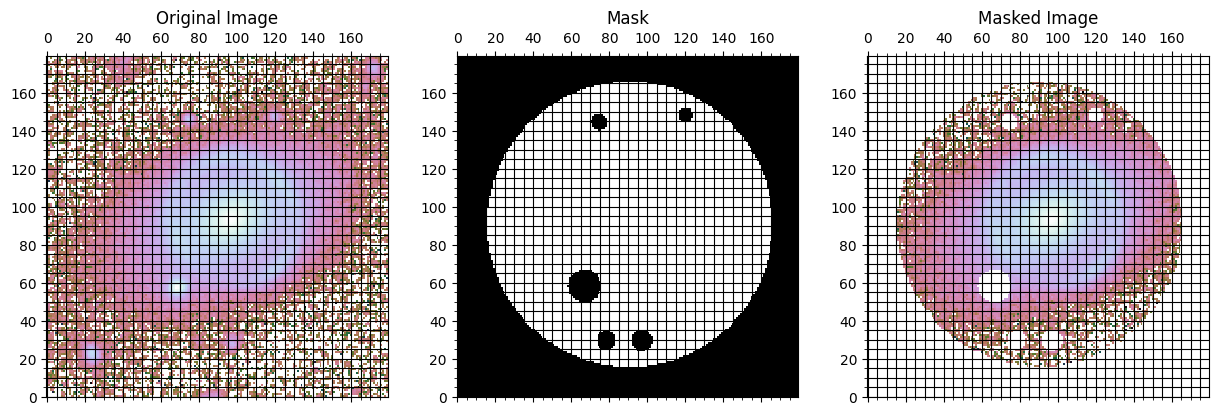

In [8]:
# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(kwargs_data['image_data']),
            origin='lower', cmap='cubehelix')
ax1.grid(which='both', color='black')
ax1.minorticks_on()
ax1.grid(which='minor', color='black')
ax1.title.set_text('Original Image')
ax2.matshow(mask_img, origin='lower', cmap='cubehelix')
ax2.grid(which='both', color='black')
ax2.minorticks_on()
ax2.grid(which='minor', color='black')
ax2.title.set_text('Mask')
ax2.title.set_text('Mask')

image = np.log10(kwargs_data["image_data"] * mask_img)

ax3.matshow(image, origin='lower', cmap='cubehelix')
ax3.grid(which='both', color='black')
ax3.minorticks_on()
ax3.grid(which='minor', color='black')
ax3.title.set_text('Masked Image')
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. We checked [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [9]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", 'SERSIC_ELLIPSE']

## Lens galaxy's mass model

In [10]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# Setting EPL Parameters

fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 2.61,
                         'gamma': 1.17,
                         'e1': 0.1058,
                         'e2': -0.155,
                         'center_x': -0.445,
                         'center_y':  0.1833})
kwargs_lens_sigma.append({'theta_E': .2,
                          'gamma': .1,
                          'e1': 0.05,
                          'e2': 0.05,
                         'center_x': 0.5,
                          'center_y': 0.5})
kwargs_lower_lens.append({'theta_E': 0.01,
                          'gamma': 1.,
                          'e1': -0.5,
                          'e2': -0.5,
                          'center_x': -10,
                          'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10.,
                          'gamma': 3.,
                          'e1': 0.5,
                          'e2': 0.5,
                          'center_x': 10,
                          'center_y': 10})


# Setting SHEAR Parameters
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.097, 'gamma2': -0.0899})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})


lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]


## Lens galaxy's light model

In [11]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


# First Sersic profile
fixed_lens_light.append({'n_sersic': 1.0})

kwargs_lens_light_init.append({'R_sersic': 0.865,
                               'n_sersic': 1,
                               'e1': 0.1223,
                               'e2': -0.1458,
                               'center_x': -0.48730,
                               'center_y': 0.197,
                               'amp': 16})
kwargs_lens_light_sigma.append({'n_sersic': 1,
                                'R_sersic': 0.3,
                                'e1': 0.05,
                                'e2': 0.05,
                                'center_x': 0.1,
                                'center_y': 0.1,
                                'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5,
                                'e2': -0.5,
                                'R_sersic': 0.001,
                                'n_sersic': .5 ,
                                'center_x': -10,
                                'center_y': -10,
                                'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5,
                                'e2': 0.5,
                                'R_sersic': 10,
                                'n_sersic': 5.,
                                'center_x': 10,
                                'center_y': 10,
                                'amp': 100})


# Second Sersic profile
fixed_lens_light.append({'n_sersic': 4.0})   # SERSIC_ELLIPSE
kwargs_lens_light_init.append({'R_sersic': 1.776,
                               'n_sersic': 4,
                               'e1': -0.188,
                               'e2': 0.185,
                               'center_x': 0.0,
                               'center_y': 0.0,
                               'amp': 10})
kwargs_lens_light_sigma.append({'n_sersic': 1,
                                'R_sersic': 0.3,
                                'e1': 0.05,
                                'e2': 0.05,
                                'center_x': 0.1,
                                'center_y': 0.1,
                                'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5,
                                'e2': -0.5,
                                'R_sersic': 0.01,
                                'n_sersic': 4.,
                                'center_x': -10,
                                'center_y': -10,
                                'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5,
                                'R_sersic': 5,
                                'n_sersic': 4.,
                                'center_x': 10,
                                'center_y': 10,
                                'amp': 100})

# joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [kwargs_lens_light_init,
                     kwargs_lens_light_sigma,
                     fixed_lens_light,
                     kwargs_lower_lens_light,
                     kwargs_upper_lens_light]


## Source galaxy's light model

In [12]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({'n_sersic': 1.})
kwargs_source_init.append({'R_sersic': 0.517,
                           'n_sersic': 1,
                           'e1': 0.4988,
                           'e2': -0.4990,
                           'center_x': -0.3454,
                           'center_y': 0.1077,
                           'amp': 16})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05,
                            'e2': 0.05,'center_x': 0.2, 'center_y': 0.2,
                            'amp': 10})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001,
            'n_sersic': .5, 'center_x': -10, 'center_y': -10,'amp': 0})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10,
        'n_sersic': 5.,  'center_x': 10, 'center_y': 10, 'amp': 100})


# SHAPELETS profile

fixed_source.append({'n_max': 6})
kwargs_source_init.append({'beta': 0.0404,
                           'center_x': -0.422,
                           'center_y': 0.171})
kwargs_source_sigma.append({'beta': 0.1,
                            'center_x': 0.2,
                            'center_y': 0.2})
kwargs_lower_source.append({'beta': 0.001, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'beta': 0.2, 'center_x': 10, 'center_y': 10})

joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]

source_params = [kwargs_source_init,
                 kwargs_source_sigma,
                 fixed_source,
                 kwargs_lower_source,
                 kwargs_upper_source]

## combining all the above specification in the `kwargs_params` dictionary

In [13]:
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {#'joint_lens_with_light': joint_lens_with_light,
                      'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
                      "joint_source_with_source": joint_source_with_source}

#### Numerical settings

Applied Mask Likelihood here

In [14]:
kwargs_likelihood = {'check_bounds': True,
                     'image_likelihood_mask_list':  [mask_img]}

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

#### Combining all the information to be sent to lenstronomy

In [15]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data,
                    kwargs_psf,
                    kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'}

## Here the model fiting is done

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
    kwargs_constraints, kwargs_likelihood, kwargs_params,
    mpi=False,
    verbose=True)

fitting_kwargs_list = [["PSO", {"sigma_scale": 1.0,
                                "n_particles": 500,
                                "n_iterations": 100}]]


chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.8775323700709536 reduced X^2 of best position
-7512.554620177434 log likelihood
17122 effective number of data points
[{'theta_E': 2.625545405200973, 'gamma': 1.257627476564636, 'e1': 0.11045767988434811, 'e2': -0.11218739828995855, 'center_x': -0.4629826489303754, 'center_y': 0.2006285318740765}, {'gamma1': 0.08772555272365398, 'gamma2': -0.08280983397310544, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.49470418863524995, 'n_sersic': 1.0, 'e1': 0.4819601273456211, 'e2': -0.3796949614678975, 'center_x': -0.4115563172328442, 'center_y': 0.17687704877739538}, {'amp': 1, 'n_max': 6, 'beta': 0.04492924270585582, 'center_x': -0.4115563172328442, 'center_y': 0.17687704877739538}] source result
[{'amp': 1, 'R_sersic': 0.9101832756674014, 'n_sersic': 1.0, 'e1': 0.10494681644229072, 'e2': -0.07346022429212025, 'center_x': -0.4913231085802907, 'center_y': 0.19726464243421454}, {'amp': 1, 'R_

## Visualizing the fitted model with `PSO`

In [ ]:
print(kwargs_result)

{'kwargs_lens': [{'theta_E': 2.625545405200973, 'gamma': 1.257627476564636, 'e1': 0.11045767988434811, 'e2': -0.11218739828995855, 'center_x': -0.4629826489303754, 'center_y': 0.2006285318740765}, {'gamma1': 0.08772555272365398, 'gamma2': -0.08280983397310544, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.49470418863524995, 'n_sersic': 1.0, 'e1': 0.4819601273456211, 'e2': -0.3796949614678975, 'center_x': -0.4115563172328442, 'center_y': 0.17687704877739538}, {'amp': 1, 'n_max': 6, 'beta': 0.04492924270585582, 'center_x': -0.4115563172328442, 'center_y': 0.17687704877739538}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.9101832756674014, 'n_sersic': 1.0, 'e1': 0.10494681644229072, 'e2': -0.07346022429212025, 'center_x': -0.4913231085802907, 'center_y': 0.19726464243421454}, {'amp': 1, 'R_sersic': 2.5768280976880433, 'n_sersic': 4.0, 'e1': 0.1495821662336176, 'e2': -0.3021980940839006, 'center_x': -0.4913231085802907, 'center_y': 0.19726464243421454}], 'kwargs_ps

-0.874824408890504 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8748244088905035


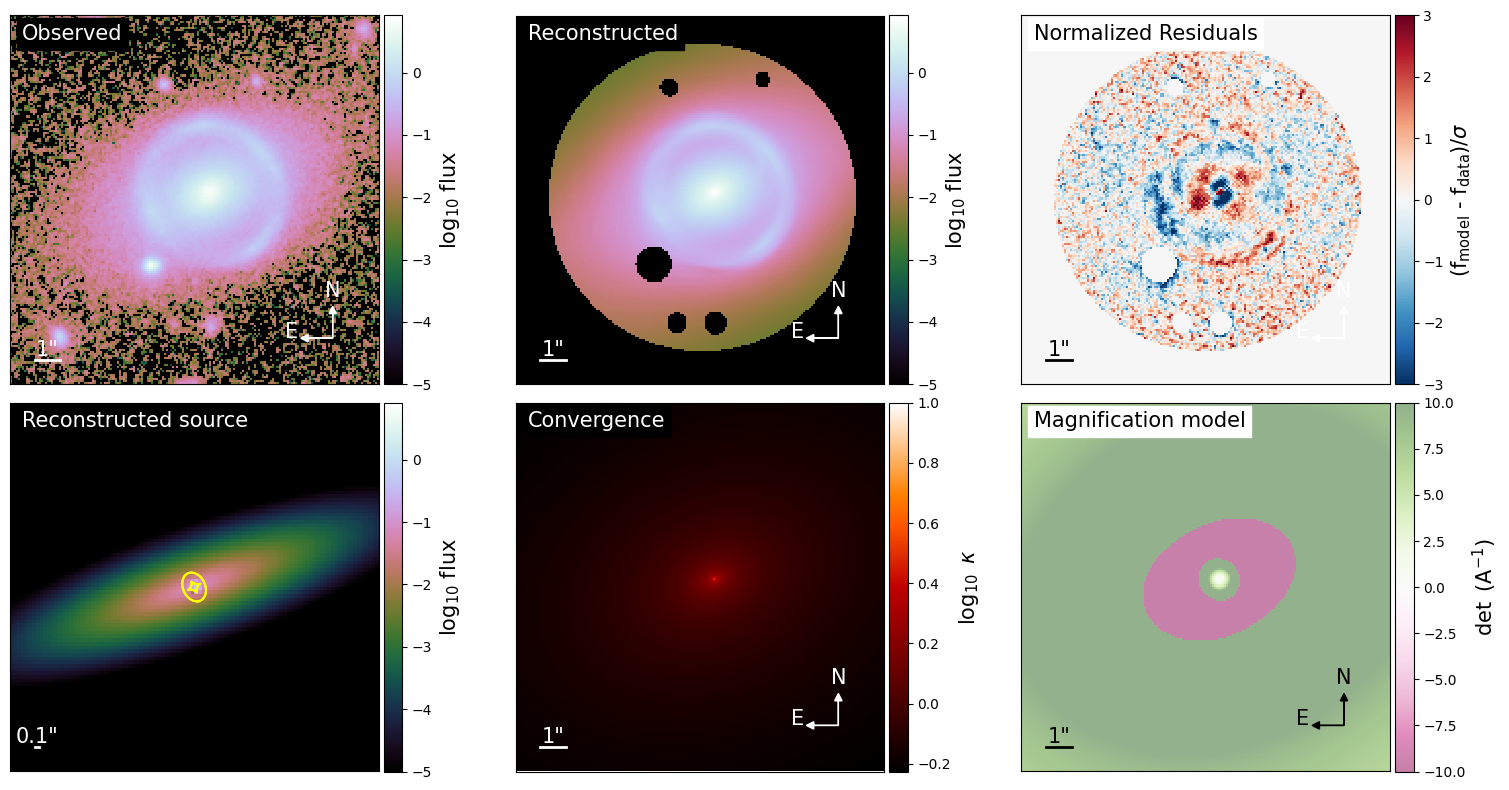

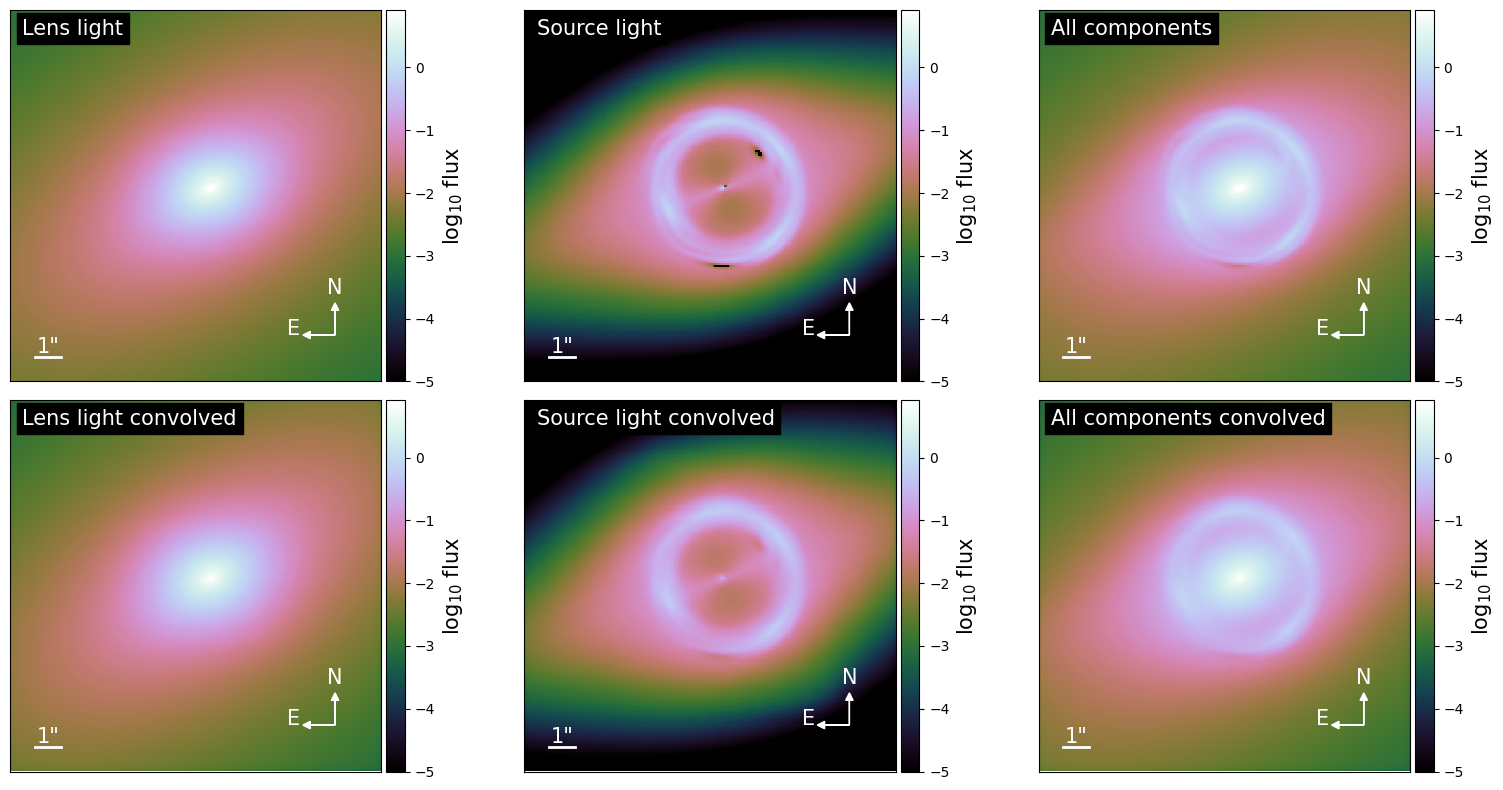

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2],
                                    v_min=-3,
                                    v_max=3,
                                    cmap="RdBu_r",
                                   )
model_plot.source_plot(ax=axes[1, 0],
                       deltaPix_source=0.08,
                       numPix=100,
                       with_caustics=True,
                      )
model_plot.convergence_plot(ax=axes[1, 1],
                            v_max=1,
                            cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2],
                              cmap="PiYG",
                             )
f.tight_layout()
f.subplots_adjust(left=None,
                  bottom=None,
                  right=None,
                  top=None,
                  wspace=0.0,
                  hspace=0.05,
                 )
plt.show()

f, axes = plt.subplots(2,
                       3,
                       figsize=(16, 8),
                       sharex=False,
                       sharey=False,
                      )

model_plot.decomposition_plot(ax=axes[0, 0],
                              text="Lens light",
                              lens_light_add=True,
                              unconvolved=True,
                             )
model_plot.decomposition_plot(ax=axes[1, 0],
                              text="Lens light convolved",
                              lens_light_add=True,
                             )
model_plot.decomposition_plot(ax=axes[0, 1],
                              text="Source light",
                              source_add=True,
                              unconvolved=True )
model_plot.decomposition_plot( ax=axes[1, 1],
                              text="Source light convolved",
                              source_add=True,
                             )
model_plot.decomposition_plot(ax=axes[0, 2],
                              text="All components",
                              source_add=True,
                              lens_light_add=True,
                              unconvolved=True,
                             )
model_plot.decomposition_plot( ax=axes[1, 2],
                              text="All components convolved",
                              source_add=True,
                              lens_light_add=True,
                              point_source_add=True,
                             )
f.tight_layout()
f.subplots_adjust(left=None, bottom=None,
                  right=None, top=None,
                  wspace=0.0, hspace=0.05)
plt.show()

In [ ]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = './DESIJ1101-0602_pso_output.joblib'

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## The *MCMC* run

In [30]:
from google.colab import files

# Define the path to the file on Google Drive
mcmc1_backend = '/content/drive/MyDrive/BDLensing/mcmc1_backend.h5'


fitting_kwargs_list_mcmc = [['MCMC', {'n_burn': 0, 'n_run': 600,
                                      'n_walkers': 80,
                                      'sigma_scale': .1, 'threadCount': 3,
                                      'backend_filename': mcmc1_backend,
                                      'start_from_backend': True}]]

fitting_seq_mcmc = FittingSequence(kwargs_data_joint, kwargs_model,
                                   kwargs_constraints,
                                   kwargs_likelihood, kwargs_params)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()


100%|██████████| 600/600 [2:08:36<00:00, 12.86s/it]


Computing the MCMC...
Number of walkers =  80
Burn-in iterations:  0
Sampling iterations (in current run): 600
7717.695146560669 time taken for MCMC sampling


In [31]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

    # Alternatively, you can access the last chain directly
    last_chain = chain_list_mcmc[-1]
    last_samples = last_chain[1]
    last_param_names = last_chain[2]
    print("Last Chain:")
    print("Sampler type:", last_chain[0])
    print("Parameter names:", last_param_names)
    print("Shape of samples:", last_samples.shape)
else:
    print("No MCMC chains available.")


Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Shape of samples: (248800, 22)

Last Chain:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Shape o

## Visualizing the MCMC chain

<ipython-input-32-742259060ab6>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 3110, N_walkers: 80, N_params: 22
theta_E_lens0 2.6454 ± 0.0028
gamma_lens0 1.0734 ± 0.0132
e1_lens0 0.1245 ± 0.0032
e2_lens0 -0.1125 ± 0.0026
center_x_lens0 -0.4708 ± 0.0052
center_y_lens0 0.2030 ± 0.0036
gamma1_lens1 0.1176 ± 0.0027
gamma2_lens1 -0.1036 ± 0.0038
R_sersic_source_light0 0.1537 ± 0.0247
e1_source_light0 0.4081 ± 0.0069
e2_source_light0 -0.4368 ± 0.0077
center_x_source_light0 -0.4025 ± 0.0060
center_y_source_light0 0.1810 ± 0.0049
beta_source_light1 0.0162 ± 0.0030
R_sersic_lens_light0 0.9381 ± 0.0054
e1_lens_light0 0.1391 ± 0.0060
e2_lens_light0 -0.0961 ± 0.0029
center_x_lens_light0 -0.4906 ± 0.0009
center_y_lens_light0 0.1964 ± 0.0009
R_sersic_lens_light1 1.9451 ± 0.1117
e1_lens_light1 0.0588 ± 0.0202
e2_lens_light1 -0.2699 ± 0.0093


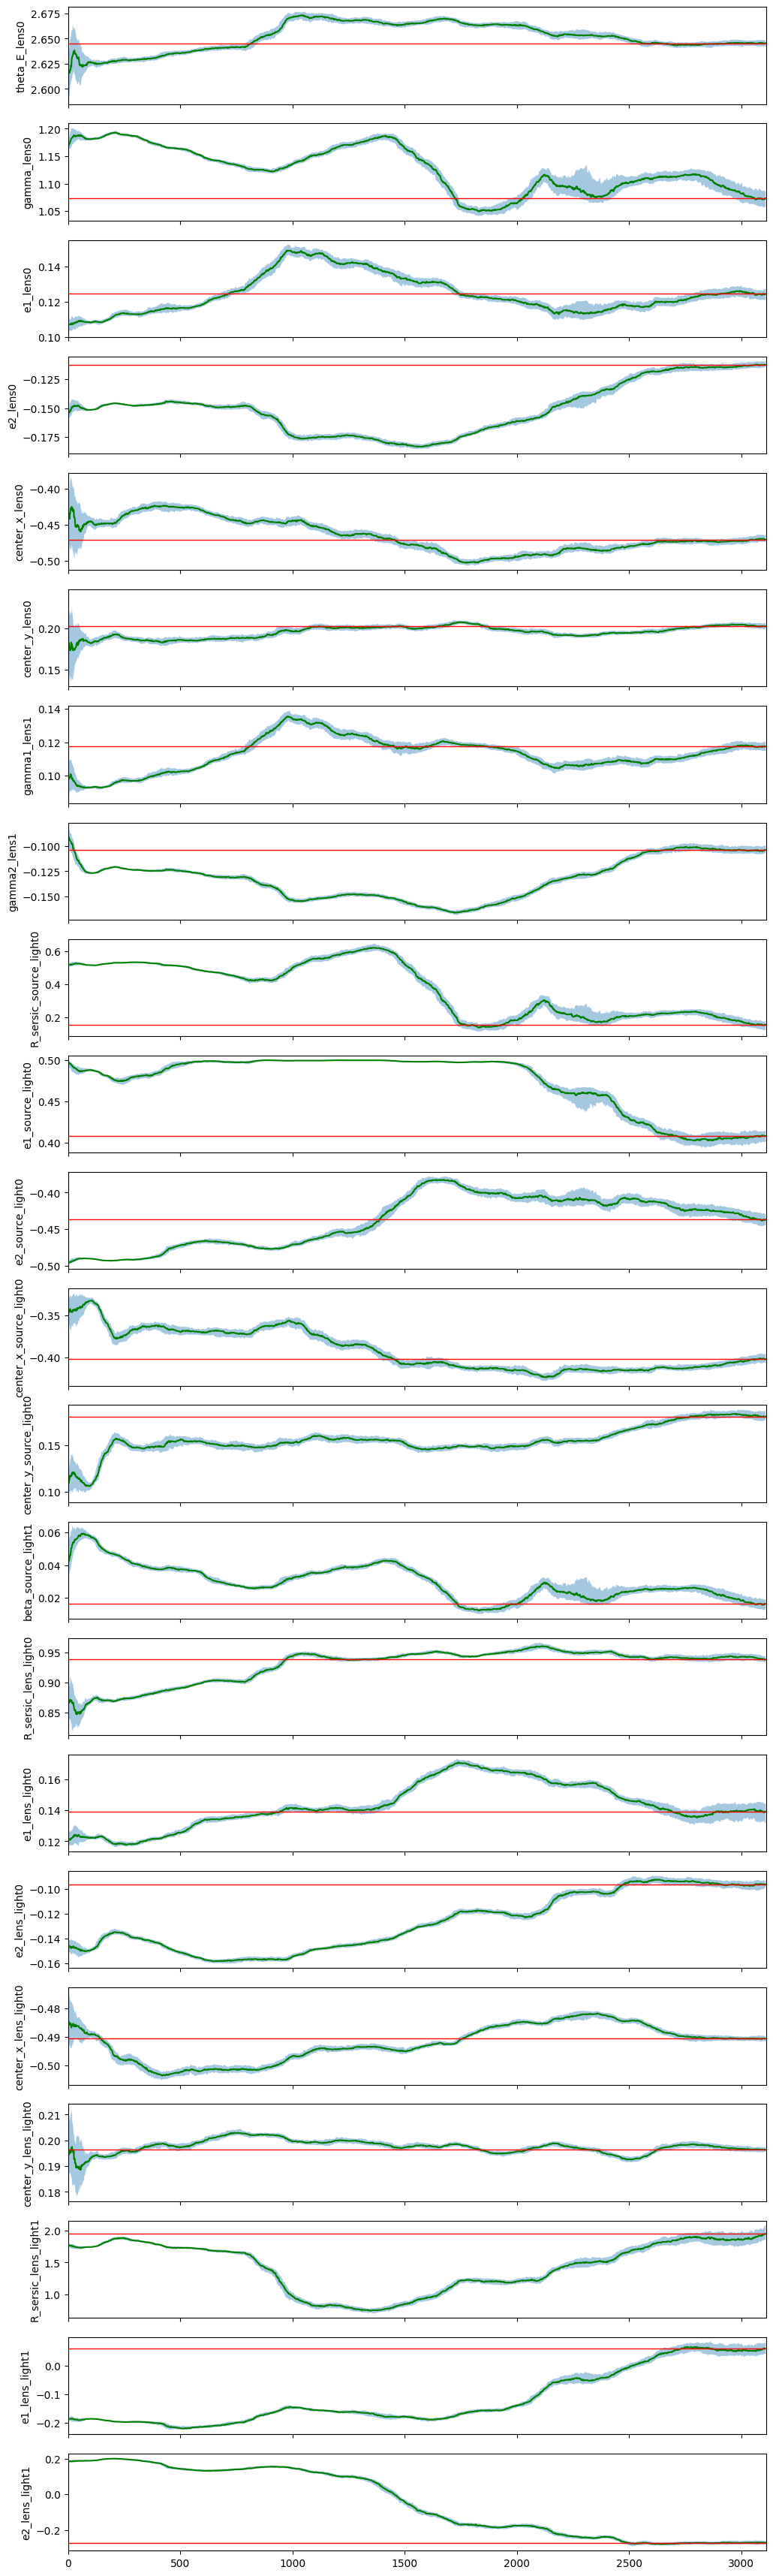

In [32]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != 'PSO':
# if MCMC chain was broken in the chunks,
# we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 80  # Adjust the walker ratio as needed
    n_step = 3110

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers,
                                                           n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order='F')
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last - 1],
     (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
                    median_pos[1][last - 1],
                     (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last - 1],
         (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last),
                           q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2 * len(param_mcmc)))
        plt.show()


Number of non-linear parameters in the MCMC process: 22
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Number of evaluations in the MCMC process: 248800
248800
Shape of samples_mcmc_cut: (880, 22)


<ipython-input-33-e6cbfc823b1f>:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


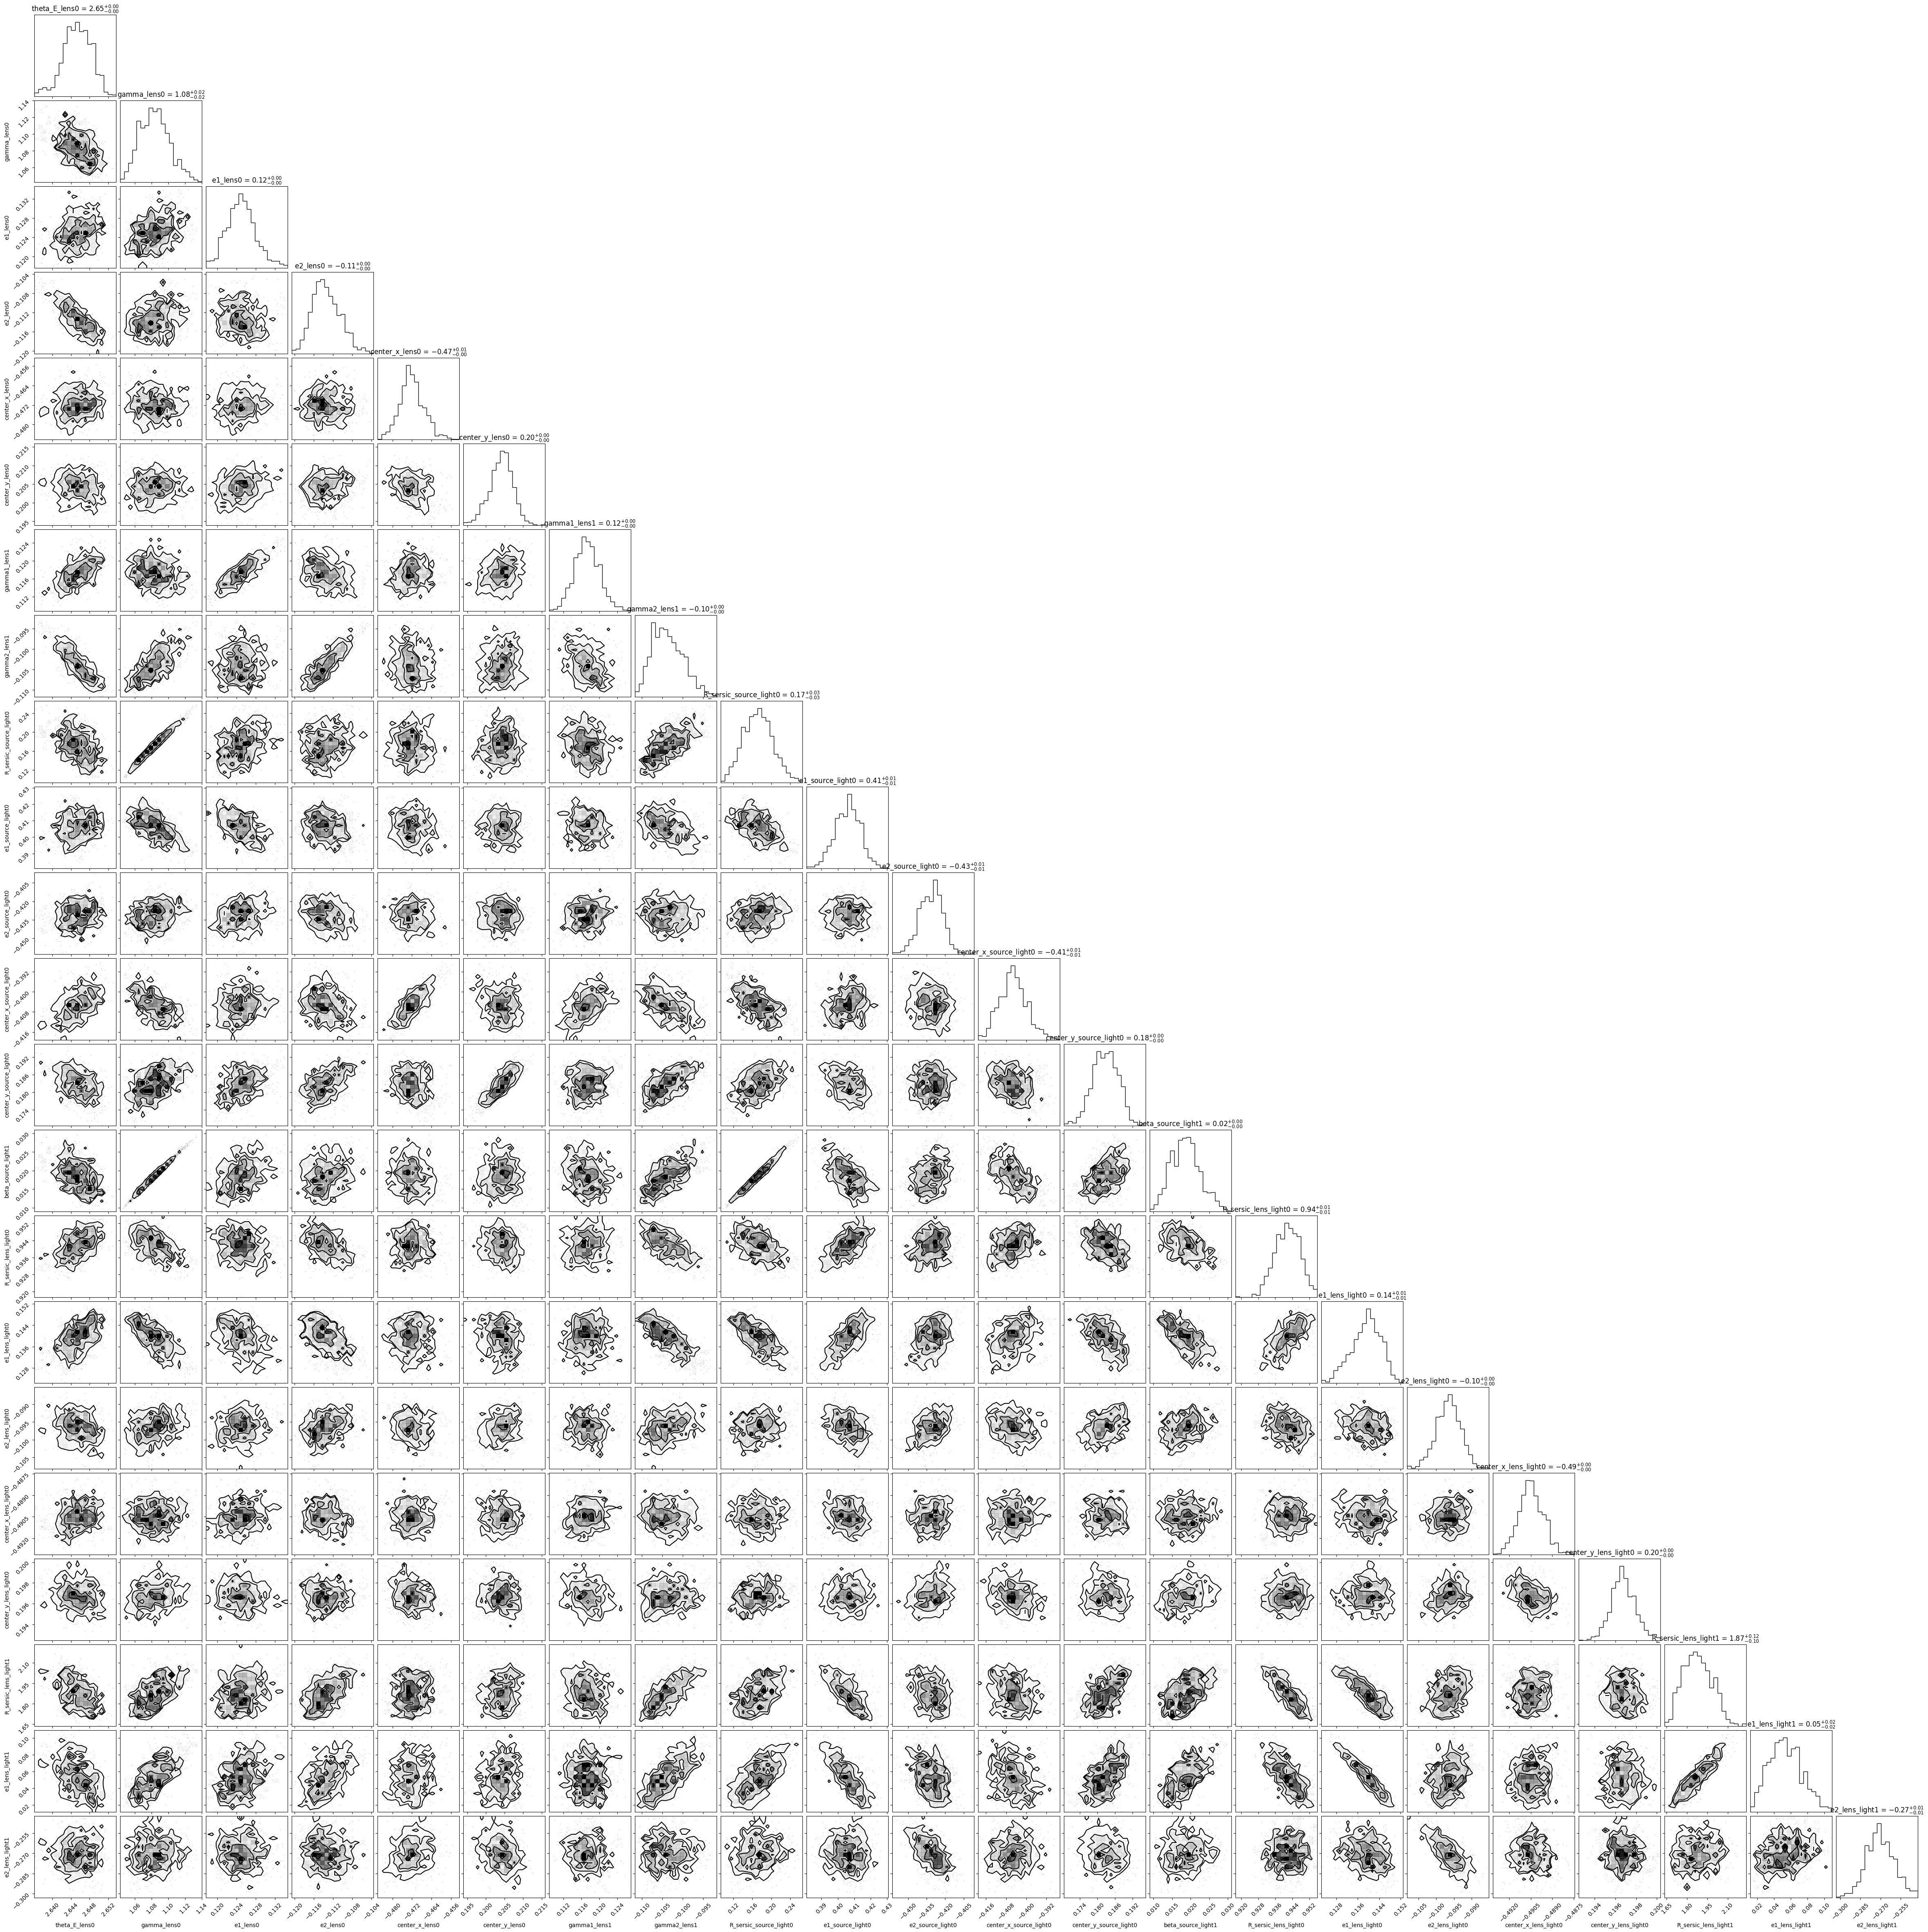

In [33]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:",
          len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:",
              np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 2900 # estimated steps where the parameters convegred
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc,
                                show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")


-0.8686893842063172 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8686893842063164


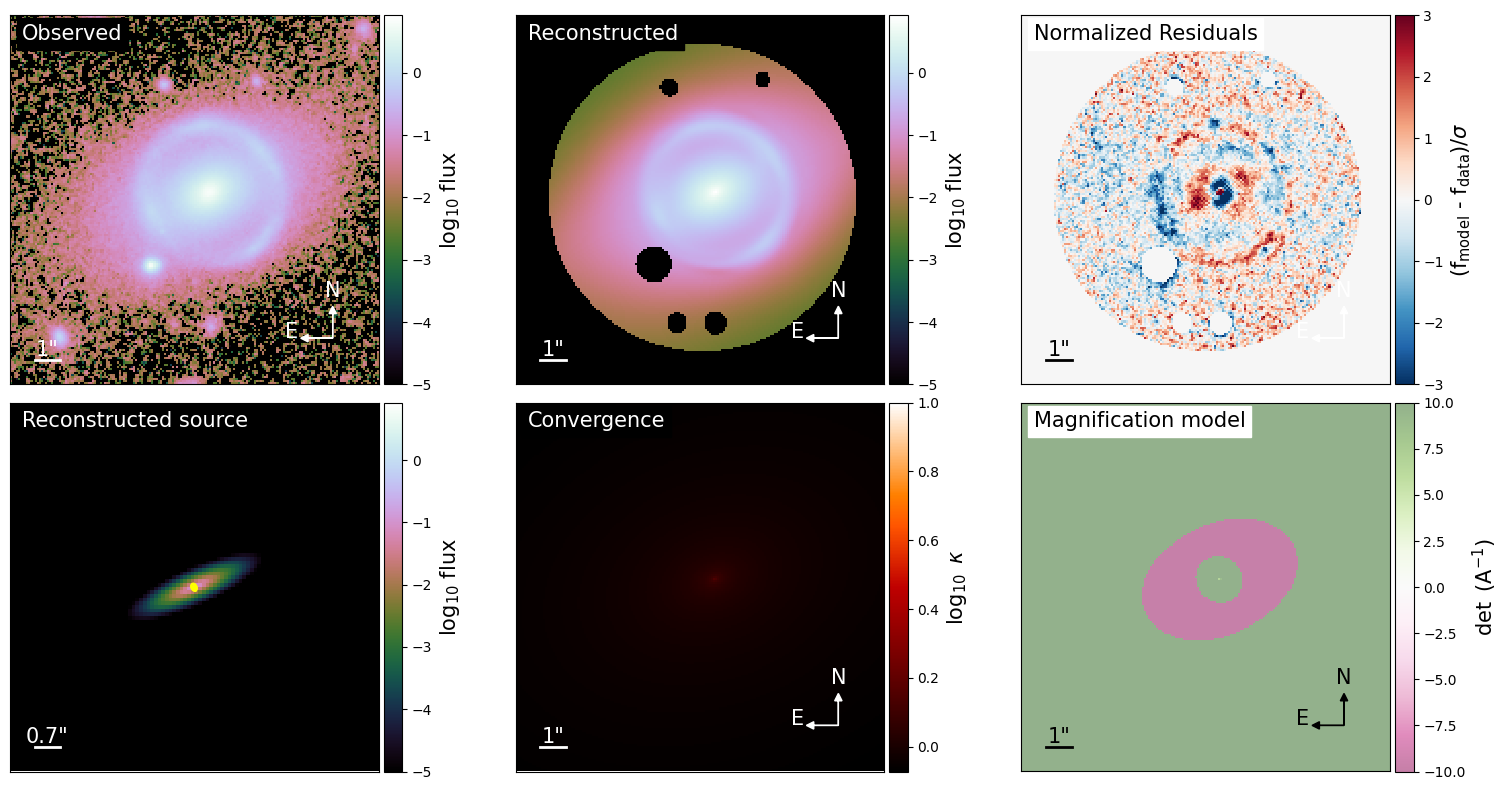

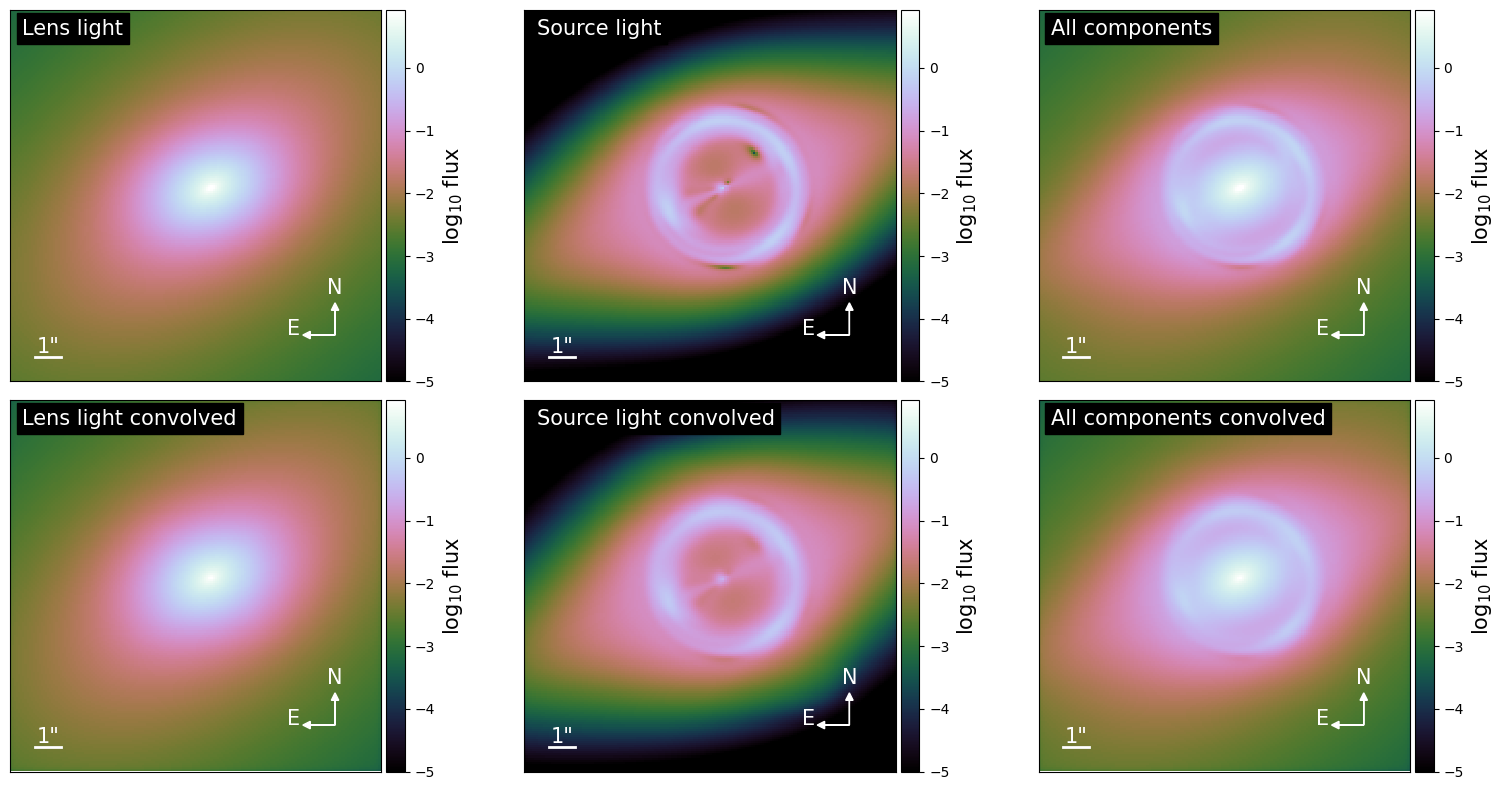

{'kwargs_lens': [{'theta_E': 2.645812267379139, 'gamma': 1.0840277813135626, 'e1': 0.1271964407204788, 'e2': -0.11253460117031176, 'center_x': -0.4712987215314124, 'center_y': 0.20240604546563487}, {'gamma1': 0.11939247509078754, 'gamma2': -0.10281890216636641, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 3.4151224294101326, 'R_sersic': 0.17200699231963038, 'n_sersic': 1.0, 'e1': 0.4061526578445177, 'e2': -0.43802766438810076, 'center_x': -0.4049320724074792, 'center_y': 0.1815626702759237}, {'amp': array([128.42236292, -17.76708886, -20.97253344,  -6.86914942,
        12.22540152,  18.33700033,   7.41922258,  -5.07543872,
        -0.70185618,   0.34552061,   4.60251321,   6.21586895,
         7.65959219,   7.58616263,   5.37617223,   2.92133023,
         4.09281407,  -2.11028417,  -1.90276726,  -7.70250232,
         0.26353647,  -9.69258563,  -1.04515159,  -3.66689216,
         7.2184459 ,  -9.65761177,  14.0278437 ,  -4.60437785]), 'n_max': 6, 'beta': 0.018569506956362756, 'cen

In [34]:
model_plot = ModelPlot(
    multi_band_list, kwargs_model, kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"]
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.1, numPix=100,
                       with_caustics=True, scale_size=0.7)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None,
                  top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0, 0], text='Lens light',
                              lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 0], text='Lens light convolved',
                              lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0, 1], text='Source light',
                              source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 1], text='Source light convolved',
                              source_add=True)
model_plot.decomposition_plot(ax=axes[0, 2], text='All components',
                              source_add=True, lens_light_add=True,
                              unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 2], text='All components convolved',
                              source_add=True, lens_light_add=True,
                              point_source_add=True)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None,
                  wspace=0., hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

In [35]:
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = 2900  # can be not `None` for MCMC

input = [fitting_kwargs_list_mcmc, multi_band_list, kwargs_model,
         kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
output = [kwargs_result_mcmc, multi_band_list_out,
          kwargs_fixed_out]

output_path = './DESIJ1101-0602_mcmc_output.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)